# Network, Graph and Graph Database

In [9]:
COLAB = True

## Environment Setup

In [8]:
# https://gist.github.com/korakot/328aaac51d78e589b4a176228e4bb06
!curl -L https://neo4j.com/artifact.php?name=neo4j-community-4.2.5-unix.tar.gz -o neo4j.tar.gz
!tar -xf neo4j.tar.gz
!mv neo4j-community-4.2.5 neo4j
!sed -i '/#dbms.security.auth_enabled/s/^#//g' neo4j/conf/neo4j.conf
!neo4j/bin/neo4j start

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  113M  100  113M    0     0  67.6M      0  0:00:01  0:00:01 --:--:-- 95.6M
Directories in use:
  home:         /content/neo4j
  config:       /content/neo4j/conf
  logs:         /content/neo4j/logs
  plugins:      /content/neo4j/plugins
  import:       /content/neo4j/import
  data:         /content/neo4j/data
  certificates: /content/neo4j/certificates
  run:          /content/neo4j/run
Starting Neo4j.
Started neo4j (pid 246). It is available at http://localhost:7474/
There may be a short delay until the server is ready.
See /content/neo4j/logs/neo4j.log for current status.


In [16]:
!pip install neo4j
!pip install tqdm

     |████████████████████████████████| 71kB 4.3MB/s  eta 0:00:01
  Created wheel for neo4j: filename=neo4j-4.2.1-cp37-none-any.whl size=95190 sha256=bd1c723e15c380e4b37b0f97d5944486966d9eb698457896b3ae04f76f02db2e
  Stored in directory: /root/.cache/pip/wheels/00/a8/69/083e04c2ffc0a7e026c9356cd5bb54c65128f3e08ef8371be0
Successfully built neo4j


## Prepare the dataset

In [14]:
if COLAB:
    # Download from Kaggle - https://www.kaggle.com/general/74235
    ! pip install -q kaggle
    
    from google.colab import files
    files.upload()    # Upload kaggle.json
    
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    
    !kaggle datasets list
    !kaggle datasets download -d Cornell-University/arxiv
    !unzip \*.zip && rm *.zip

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-30 20:52:11           4089  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2351  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            524  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:4

In [15]:
# https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4
# https://colab.research.google.com/drive/1J9__HotNoINHpucoipLH-4qWc48GALAk?usp=sharing

## EDA

In [17]:
%matplotlib inline

import json
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from neo4j import GraphDatabase

In [18]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [19]:
def get_author_list(line):
    # Cleans author dataframe column, creating a list of authors in the row.
    
    return [e[1] + ' ' + e[0] for e in line]


def get_category_list(line):
    # Cleans category dataframe column, creating a list of categories in the
    # row.
    
    return list(line.split(" "))


def add_categories(categories):
    # Adds category nodes to the Neo4j graph.
  
    query = '''UNWIND $rows AS row
    MERGE (c:Category {category: row.category})
    RETURN count(*) as total
    '''
    
    return conn.query(query, parameters={'rows': categories.to_dict('records')})


def add_authors(rows, batch_size=10000):
    # Adds author nodes to the Neo4j graph as a batch job.

    query = '''UNWIND $rows AS row
               MERGE (:Author {name: row.author})
               RETURN count(*) as total
    '''
    return insert_data(query, rows, batch_size)


def add_papers(rows, batch_size=5000):
    # Adds paper nodes and (:Author)--(:Paper) and (:Paper)--(:Category)
    # relationships to the Neo4j graph as a batch job.  (Note the smaller batch
    # size due to the fact that this function is adding much more data than the
    # add_authors() function.)

    query = '''
    UNWIND $rows as row
    MERGE (p:Paper {id:row.id}) ON CREATE SET p.title = row.title

    // connect categories
    WITH row, p
    UNWIND row.category_list AS category_name
    MATCH (c:Category {category: category_name})
    MERGE (p)-[:IN_CATEGORY]->(c)

    // connect authors
    WITH distinct row, p // reduce cardinality
    UNWIND row.cleaned_authors_list AS author
    MATCH (a:Author {name: author})
    MERGE (a)-[:AUTHORED]->(p)
    RETURN count(distinct p) as total
    '''

    return insert_data(query, rows, batch_size)


def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result


In [20]:
file = "./arxiv-metadata-oai-snapshot.json"

metadata  = []

lines = 100000    # 100k for testing
with open(file, 'r') as f:
    for line in tqdm(f): 
        metadata.append(json.loads(line))
        lines -= 1
        if lines == 0: break

df = pd.DataFrame(metadata)
df.head()

97132it [00:03, 25316.27it/s]


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [21]:
df['cleaned_authors_list'] = df['authors_parsed'].map(get_author_list)
df['category_list'] = df['categories'].map(get_category_list)
df = df.drop(['submitter', 'authors', 'comments', 'journal-ref', 'doi', 
              'report-no', 'license', 'versions', 'update_date', 'abstract', 
              'authors_parsed', 'categories'], axis=1)
df.head()

,id,title,cleaned_authors_list,category_list
0,0704.0001,Calculation of prompt diphoton production cros...,"[C. Balázs, E. L. Berger, P. M. Nadolsky, C. -...",[hep-ph]
1,0704.0002,Sparsity-certifying Graph Decompositions,"[Ileana Streinu, Louis Theran]","[math.CO, cs.CG]"
2,0704.0003,The evolution of the Earth-Moon system based o...,[Hongjun Pan],[physics.gen-ph]
3,0704.0004,A determinant of Stirling cycle numbers counts...,[David Callan],[math.CO]
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"[Wael Abu-Shammala, Alberto Torchinsky]","[math.CA, math.FA]"


In [22]:
categories = pd.DataFrame(df[['category_list']])
categories.rename(columns={'category_list':'category'}, inplace=True)
categories = categories.explode('category').drop_duplicates(subset=['category'])

categories.size

148

In [23]:
authors = pd.DataFrame(df[['cleaned_authors_list']])

authors.rename(columns={'cleaned_authors_list':'author'}, inplace=True)
authors=authors.explode('author').drop_duplicates(subset=['author'])

authors.size

135410

In [27]:
conn = Neo4jConnection(uri="bolt://0.0.0.0:7687", user="neo4j", pwd="neo4j")

In [28]:
conn.query('CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper) ASSERT p.id IS UNIQUE')
conn.query('CREATE CONSTRAINT authors IF NOT EXISTS ON (a:Author) ASSERT a.name IS UNIQUE')
conn.query('CREATE CONSTRAINT categories IF NOT EXISTS ON (c:Category) ASSERT c.category IS UNIQUE')

[]

In [29]:
add_categories(categories)

[<Record total=148>]

In [30]:
add_authors(authors)

{'total': 10000, 'batches': 1, 'time': 2.371570348739624}
{'total': 20000, 'batches': 2, 'time': 3.809314250946045}
{'total': 30000, 'batches': 3, 'time': 5.068058013916016}
{'total': 40000, 'batches': 4, 'time': 6.188276290893555}
{'total': 50000, 'batches': 5, 'time': 7.204348087310791}
{'total': 60000, 'batches': 6, 'time': 8.139954090118408}
{'total': 70000, 'batches': 7, 'time': 9.073742389678955}
{'total': 80000, 'batches': 8, 'time': 9.963227272033691}
{'total': 90000, 'batches': 9, 'time': 10.74406909942627}
{'total': 100000, 'batches': 10, 'time': 11.533184051513672}
{'total': 110000, 'batches': 11, 'time': 12.16784930229187}
{'total': 120000, 'batches': 12, 'time': 12.78803277015686}
{'total': 130000, 'batches': 13, 'time': 13.398576736450195}
{'total': 135410, 'batches': 14, 'time': 13.829177856445312}


{'batches': 14, 'time': 13.829177856445312, 'total': 135410}

In [31]:
add_papers(df)

{'total': 5000, 'batches': 1, 'time': 4.665409803390503}
{'total': 10000, 'batches': 2, 'time': 7.182037830352783}
{'total': 15000, 'batches': 3, 'time': 9.731791496276855}
{'total': 20000, 'batches': 4, 'time': 11.747239828109741}
{'total': 25000, 'batches': 5, 'time': 13.515150308609009}
{'total': 30000, 'batches': 6, 'time': 15.112334728240967}
{'total': 35000, 'batches': 7, 'time': 16.70318603515625}
{'total': 40000, 'batches': 8, 'time': 18.445334672927856}
{'total': 45000, 'batches': 9, 'time': 20.187700033187866}
{'total': 50000, 'batches': 10, 'time': 21.81722593307495}
{'total': 55000, 'batches': 11, 'time': 23.531256675720215}
{'total': 60000, 'batches': 12, 'time': 26.575834274291992}
{'total': 65000, 'batches': 13, 'time': 30.470590829849243}
{'total': 70000, 'batches': 14, 'time': 32.91064953804016}
{'total': 75000, 'batches': 15, 'time': 35.95437574386597}
{'total': 80000, 'batches': 16, 'time': 38.15401268005371}
{'total': 85000, 'batches': 17, 'time': 39.82299447059631}

{'batches': 20, 'time': 45.64205288887024, 'total': 100000}

In [32]:
query_string = '''
MATCH (c:Category) 
RETURN c.category, SIZE(()-[:IN_CATEGORY]->(c)) AS inDegree 
ORDER BY inDegree DESC LIMIT 20
'''

top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
top_cat_df.head(20)

,c.category,inDegree
0,astro-ph,19697
1,hep-ph,9506
2,hep-th,8857
3,quant-ph,6279
4,gr-qc,5282
5,cond-mat.mtrl-sci,4553
6,cond-mat.stat-mech,4380
7,cond-mat.str-el,4344
8,math.MP,4334
9,math-ph,4334


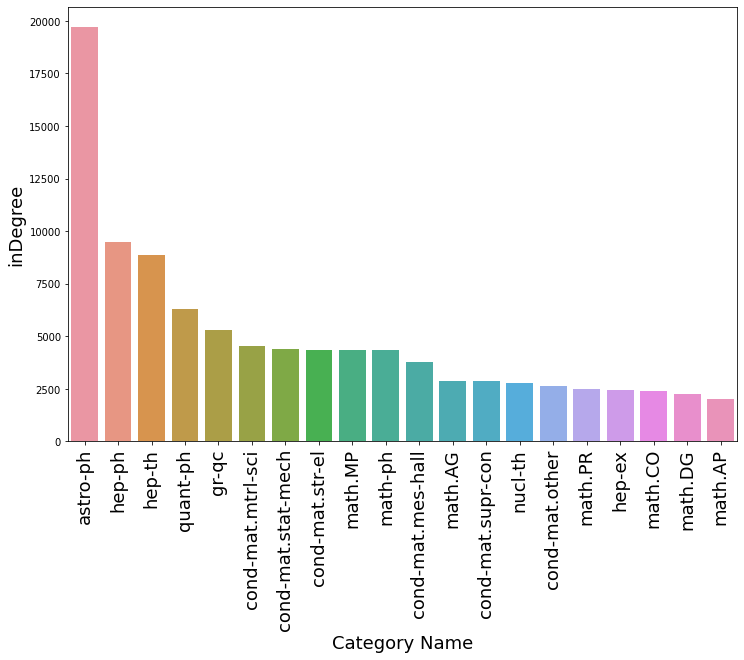

In [33]:
plt.figure(figsize=(12,8))
sns.barplot(x=top_cat_df['c.category'], y=top_cat_df['inDegree'])
plt.xlabel('Category Name', fontsize=18)
plt.ylabel('inDegree',fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)
plt.show()

In [34]:
result = conn.query(query_string)

for record in result:
    print(record[0], record[1])

astro-ph 19697
hep-ph 9506
hep-th 8857
quant-ph 6279
gr-qc 5282
cond-mat.mtrl-sci 4553
cond-mat.stat-mech 4380
cond-mat.str-el 4344
math.MP 4334
math-ph 4334
cond-mat.mes-hall 3761
math.AG 2893
cond-mat.supr-con 2857
nucl-th 2769
cond-mat.other 2630
math.PR 2480
hep-ex 2461
math.CO 2397
math.DG 2237
math.AP 1996
